In [ ]:
def trayectoria(t0, tf, q0, qf, n=100):
    
    from numpy import linspace
    
    v = (3/2)*(qf - q0)/tf
    tb = (q0 - qf + v*tf - 2*v*t0)/v
    a = v/(tb - t0)
    ts = linspace(t0, tf, n)
    
    qs = []
    q̇s = []
    q̈s = []
    
    for t in ts:
        if t <= tb:
            qs.append(q0 + a/2*(t - t0)**2)
            q̇s.append(a*(t - t0))
            q̈s.append(a)
        else:
            if t <= tf - tb:
                qs.append(q0 + a/2*(tb - t0)**2 + v*(t - tb))
                q̇s.append(v)
                q̈s.append(0)
            else:
                if t <= tf:
                    qs.append(qf - (a/2)*(tf)**2 + a*(tf)*t - (a/2)*(t)**2)
                    q̇s.append(v - a*(t - tf + tb))
                    q̈s.append(-a)
                    
    return ts, qs, q̇s, q̈s, tb

In [2]:
def grafica_trayectoria(t0, tf, q0, qf, n=100):
    
    from matplotlib.pyplot import figure, subplots
    %matplotlib inline
    
    ts, qs, q̇s, q̈s, tb = trayectoria(t0, tf, q0, qf, 1000)

    fig, axes = subplots(nrows=1, ncols=3, figsize=(17, 5))

    axes[0].plot(ts, qs)
    axes[1].plot(ts, q̇s)
    axes[2].plot(ts, q̈s)
    
    datos = qs, q̇s, q̈s
    mins = [min(arreglo) for arreglo in datos]
    maxs = [max(arreglo) for arreglo in datos]
    spans = [ma - mi for ma, mi in zip(maxs, mins)]
    Δt = tf - t0

    axes[0].plot([tb, tb], [mins[0] - 0.1*spans[0], maxs[0] + 0.1*spans[0]], "--")
    axes[0].plot([tf - tb, tf - tb], [mins[0] - 0.1*spans[0], maxs[0] + 0.1*spans[0]], "--")
    axes[0].set_xlim(-0.1*Δt + t0, 0.1*Δt + tf)
    axes[0].set_ylim(-0.1*spans[0] + mins[0], 0.1*spans[0] + maxs[0])

    axes[1].plot([tb, tb], [mins[1] - 0.1*spans[1], maxs[1] + 0.1*spans[1]], "--")
    axes[1].plot([tf - tb, tf - tb], [mins[1] - 0.1*spans[1], maxs[1] + 0.1*spans[1]], "--")
    axes[1].set_xlim(-0.1*Δt + t0, 0.1*Δt + tf)
    axes[1].set_ylim(-0.1*spans[1] + mins[1], 0.1*spans[1] + maxs[1])

    axes[2].plot([tb, tb], [mins[2] - 0.1*spans[2], maxs[2] + 0.1*spans[2]], "--")
    axes[2].plot([tf - tb, tf - tb], [mins[2] - 0.1*spans[2], maxs[2] + 0.1*spans[2]], "--")
    axes[2].set_xlim(-0.1*Δt + t0, 0.1*Δt + tf)
    axes[2].set_ylim(-0.1*spans[2] + mins[2], 0.1*spans[2] + maxs[2])
    
    return ts, qs, q̇s

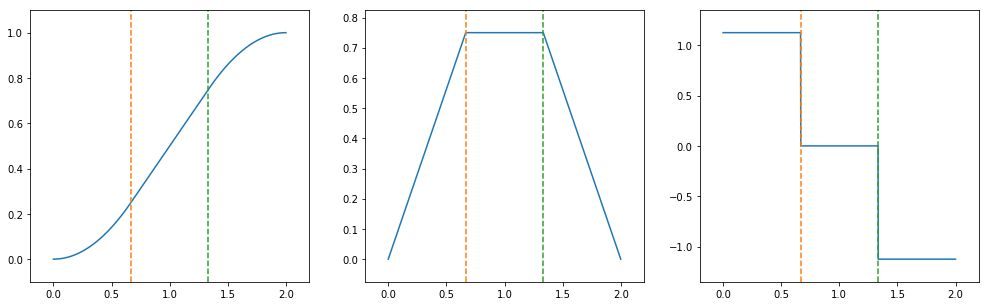

In [213]:
ts, q1, q̇1 = grafica_trayectoria(0, 2, 0, 1, 1000)

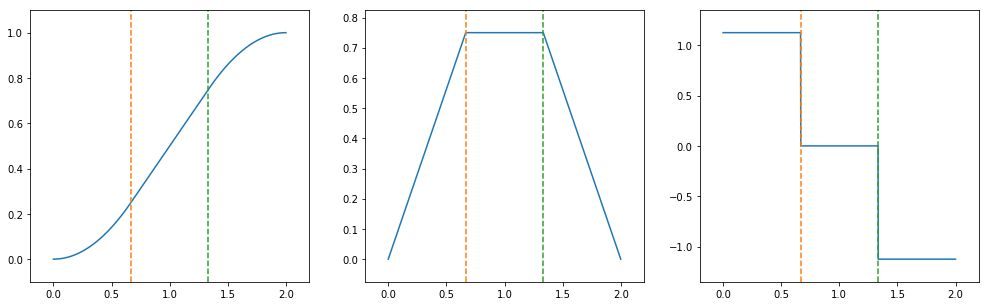

In [214]:
ts, q2, q̇2 = grafica_trayectoria(0, 2, 0, 1, 1000)

In [238]:
estado_deseado = q1, q2, q̇1, q̇2
tiempos = ts.tolist()
int(tiempos[-1]*500)- 1

999

In [216]:
from scipy.integrate import odeint
from numpy import linspace

In [239]:
def control_pd(estado, tiempo):
    
    q1, q2, q̇1, q̇2 = estado
    qd1, qd2, q̇d1, q̇d2 = estado_deseado
    i = int(tiempo*500)-1
    a, b, c, d = qd1[i], qd2[i], q̇d1[i], q̇d2[i]
    
    kp1, kp2 = 1000, 600
    kv1, kv2 = 50, 80
    
    τ1 = kp1*(a - q1) + kv1*(c - q̇1)
    τ2 = kp2*(b - q2) + kv2*(d - q̇2)
    
    return τ1, τ2

def señales(tiempo, q1, q2, q̇1, q̇2, ts):
    i = ts.index(tiempo)
    return q1[i], q2[i], q̇1[i], q̇2[i]

In [240]:
def pendulo_doble(estado, tiempo):
    # Se importan funciones necesarias
    from numpy import sin, cos, matrix
    # Se desenvuelven variables del estado y tiempo
    q1, q2, q̇1, q̇2 = estado
    t = tiempo
    
    # Se declaran constantes del sistema
    m1, m2 = 1, 1
    l1, l2 = 1, 1
    g = 9.81
    
    # Se declaran constantes del control
    #kp1, kp2 = -30, -60
    #kv1, kv2 = -20, -20
    
    # Señales de control nulas
    #tau1, tau2 = 0, 0
    
    # Posiciones a alcanzar
    #qd1, qd2 = 1, 1
    
    # Se declaran señales de control del sistema
    #tau1 = kp1*(q1 - qd1) + kv1*q̇1
    #tau2 = kp2*(q2 - qd2) + kv2*q̇2
    tau1, tau2 = control_pd(estado, tiempo)
    tau1 += m1*l1*cos(q1) + m2*l1*cos(q1) + m2*l2*cos(q1 + q2)
    tau2 += m2*l2*cos(q1 + q2)
    
    # Se calculan algunos terminos comunes
    ϕ1 = m1*l1**2
    ϕ2 = m2*l1*l2
    ϕ3 = m2*l2**2
    
    # Se calculan las matrices de masas, Coriolis,
    # y vectores de gravedad, control, posicion y velocidad
    M = matrix([[2*ϕ1 + 2*ϕ2*cos(q2) + ϕ3, ϕ2*cos(q2) + ϕ3],
                [ϕ2*cos(q2) + ϕ3, ϕ3]])
    C = -2*ϕ2*sin(q2)*matrix([[q̇2, q̇2], [-q̇1, 0]])
    G = matrix([[m1*l1*cos(q1) + m2*l1*cos(q1) + m2*l2*cos(q1 + q2)], [m2*l2*cos(q1 + q2)]])
    Tau = matrix([[tau1], [tau2]])
    q = matrix([[q1], [q2]])
    q̇ = matrix([[q̇1], [q̇2]])
    
    # Se calcula la derivada del estado del sistema
    qp1 = q̇1
    qp2 = q̇2
    
    qpp = M.I*(Tau - C*q̇ - G)
    qpp1, qpp2 = qpp.tolist()
    
    return [qp1, qp2, qpp1[0], qpp2[0]]

In [241]:
estados_simulados = odeint(func = pendulo_doble, y0 = [0, 0, 0, 0], t = ts)

In [242]:
a, b, c, d = list(zip(*estados_simulados.tolist()))

In [243]:
%matplotlib inline
from matplotlib.pyplot import subplots

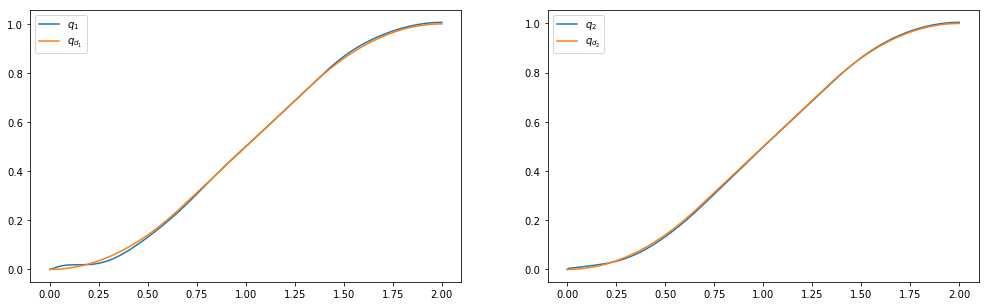

In [256]:
fig, axes = subplots(nrows=1, ncols=2, figsize=(17, 5))

p1, = axes[0].plot(ts, a)
p2, = axes[1].plot(ts, b)

p3, = axes[0].plot(ts, q1)
p4, = axes[1].plot(ts, q2)

axes[0].legend([p1, p3],[r"$q_1$", r"$q_{d_1}$"])
axes[1].legend([p2, p4],[r"$q_2$", r"$q_{d_2}$"])
#ax1.set_ylim(-4, 4)
axes[0].set_xlim(-0.1, 2.1)
axes[1].set_xlim(-0.1, 2.1);

In [251]:
from numpy import array, pi

In [252]:
e1, e2 = 180/pi*(array(a) - array(q1)), 180/pi*(array(b) - array(q2))

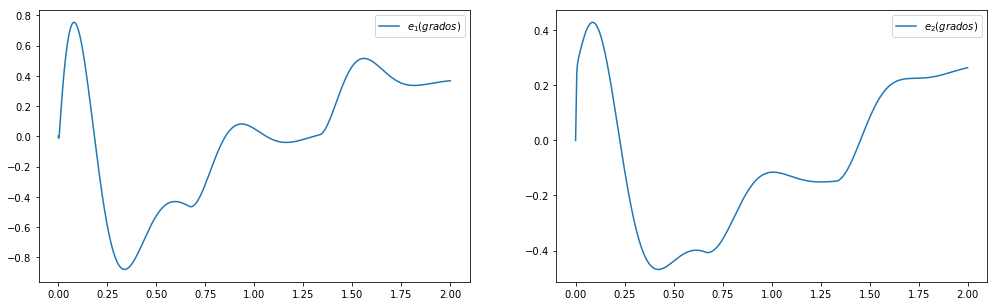

In [254]:
fig, axes = subplots(nrows=1, ncols=2, figsize=(17, 5))

p1, = axes[0].plot(ts, e1)
p2, = axes[1].plot(ts, e2)

axes[0].legend([p1],[r"$e_1 (grados)$"])
axes[1].legend([p2],[r"$e_2 (grados)$"])
#ax1.set_ylim(-4, 4)
axes[0].set_xlim(-0.1, 2.1)
axes[1].set_xlim(-0.1, 2.1);